<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Carga-de-los-datos" data-toc-modified-id="Carga-de-los-datos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Carga de los datos</a></span></li><li><span><a href="#Entregable" data-toc-modified-id="Entregable-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Entregable</a></span><ul class="toc-item"><li><span><a href="#Análisis-de-los-datos" data-toc-modified-id="Análisis-de-los-datos-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Análisis de los datos</a></span><ul class="toc-item"><li><span><a href="#Split-data" data-toc-modified-id="Split-data-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Split data</a></span></li><li><span><a href="#Normalization-and-Categorical-Vectors" data-toc-modified-id="Normalization-and-Categorical-Vectors-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Normalization and Categorical Vectors</a></span></li></ul></li><li><span><a href="#Parametros-del-modelo-y-callbacks" data-toc-modified-id="Parametros-del-modelo-y-callbacks-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Parametros del modelo y callbacks</a></span></li><li><span><a href="#Definicion-del-modelo-Fully-Connected" data-toc-modified-id="Definicion-del-modelo-Fully-Connected-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Definicion del modelo Fully Connected</a></span><ul class="toc-item"><li><span><a href="#Reshape-de-las-imágenes-a-1-único-vector" data-toc-modified-id="Reshape-de-las-imágenes-a-1-único-vector-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Reshape de las imágenes a 1 único vector</a></span></li><li><span><a href="#Definicion-del-modelo" data-toc-modified-id="Definicion-del-modelo-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Definicion del modelo</a></span></li><li><span><a href="#Graficas-del-modelo" data-toc-modified-id="Graficas-del-modelo-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Graficas del modelo</a></span></li><li><span><a href="#Evaluacion" data-toc-modified-id="Evaluacion-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Evaluacion</a></span></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></li><li><span><a href="#Mejoras-del-modelo:-CNN" data-toc-modified-id="Mejoras-del-modelo:-CNN-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Mejoras del modelo: CNN</a></span><ul class="toc-item"><li><span><a href="#Definicion-del-modelo" data-toc-modified-id="Definicion-del-modelo-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Definicion del modelo</a></span></li><li><span><a href="#Gráficas-del-modelo" data-toc-modified-id="Gráficas-del-modelo-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Gráficas del modelo</a></span></li><li><span><a href="#Evaluación-del-modelo" data-toc-modified-id="Evaluación-del-modelo-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Evaluación del modelo</a></span></li><li><span><a href="#Análisis-visual:-Matriz-de-confusion" data-toc-modified-id="Análisis-visual:-Matriz-de-confusion-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>Análisis visual: Matriz de confusion</a></span></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-2.4.5"><span class="toc-item-num">2.4.5&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Data augmentation</a></span><ul class="toc-item"><li><span><a href="#Data-Generator" data-toc-modified-id="Data-Generator-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Data Generator</a></span></li><li><span><a href="#Definicion-del-modelo" data-toc-modified-id="Definicion-del-modelo-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Definicion del modelo</a></span></li><li><span><a href="#Gráficas" data-toc-modified-id="Gráficas-2.5.3"><span class="toc-item-num">2.5.3&nbsp;&nbsp;</span>Gráficas</a></span></li><li><span><a href="#Evaluacion-del-Modelo" data-toc-modified-id="Evaluacion-del-Modelo-2.5.4"><span class="toc-item-num">2.5.4&nbsp;&nbsp;</span>Evaluacion del Modelo</a></span></li><li><span><a href="#Análisis-visual" data-toc-modified-id="Análisis-visual-2.5.5"><span class="toc-item-num">2.5.5&nbsp;&nbsp;</span>Análisis visual</a></span></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-2.5.6"><span class="toc-item-num">2.5.6&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></li></ul></li></ul></div>

# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [294]:
import cv2
import os
import numpy as np 
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer, Conv2D, MaxPooling2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [242]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="/home/diicic/master/SCART/simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /home/diicic/master/SCART/simpsons_train.tar.gz -C /home/diicic/master/SCART/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="/home/diicic/master/SCART/simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /home/diicic/master/SCART/simpsons_test.tar.gz -C /home/diicic/master/SCART/datasets

In [243]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [244]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [245]:
def load_train_set_gray(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            image = cv2.resize(image,(IMG_SIZE, IMG_SIZE))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X_train.append(image)
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [246]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [247]:
def load_test_set_gray(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [299]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    matplotlib.rcParams['figure.figsize'] = [15, 15]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [272]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
    

In [256]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/home/diicic/master/SCART/datasets/simpsons/"
DATASET_TEST_PATH_COLAB = "/home/diicic/master/SCART/datasets/simpsons_testset/"

X_train, y_train = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

X_g_train, y_g_train = load_train_set_gray(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_g_test, y_g_test = load_test_set_gray(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test
Leyendo 913 imágenes encon

In [257]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X_train))
X_train, y_train = X_train[perm], y_train[perm]
X_g_train, y_g_train = X_g_train[perm], y_g_train[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

### Análisis de los datos

In [260]:
print("Tamaño y número de muestras de las imagenes")

img_width = X.shape[1]
img_height = X.shape[2]

print("Tenemos ", X.shape[0], 
      "imágenes de tamaño ",img_width, 
      "X", img_height,
     "en RGB (", X.shape[3],
      "capas)")

print("Hay que separar los datos en:", round(18992*0.8), 
      "imágenes de train y",round(18992*0.2), 
      "Imágenes de validation.")

print(X_g_train.shape)
print(X_train.shape)

Tamaño y número de muestras de las imagenes
Tenemos  18992 imágenes de tamaño  64 X 64 en RGB ( 3 capas)
Hay que separar los datos en: 15194 imágenes de train y 3798 Imágenes de validation.
(18992, 64, 64)
(18992, 64, 64, 3)


Tamaño y número de muestras de las imagenes. 
Tenemos  18992 imágenes de tamaño  64 X 64 en RGB ( 3 capas). 
Hay que separar los datos en: 15194 imágenes de train y 3798 Imágenes de validation.

#### Split data

In [261]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2)
X_g_train, X_g_validate, y_g_train, y_g_validate = train_test_split(X_g_train, y_g_train, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(15193, 64, 64, 3) (15193,)
(3799, 64, 64, 3) (3799,)
(890, 64, 64, 3) (890,)


#### Normalization and Categorical Vectors

In [262]:
NB_CLASSES = 18

#float and normalization
X_train = X_train.astype('float32') / 255
X_validate = X_validate.astype('float32') / 255
X_test = X_test.astype('float32') / 255

#float and normalization
X_g_train = X_g_train.astype('float32') / 255
X_g_validate = X_g_validate.astype('float32') / 255
X_g_test = X_g_test.astype('float32') / 255


#One Hot Vectors
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
y_validate = np_utils.to_categorical(y_validate, NB_CLASSES)
y_test = np_utils.to_categorical(y_test, NB_CLASSES)

#One Hot Vectors
y_g_train = np_utils.to_categorical(y_g_train, NB_CLASSES)
y_g_validate = np_utils.to_categorical(y_g_validate, NB_CLASSES)
y_g_test = np_utils.to_categorical(y_g_test, NB_CLASSES)

print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(15193, 64, 64, 3) (15193, 18)
(3799, 64, 64, 3) (3799, 18)
(890, 64, 64, 3) (890, 18)


### Parametros del modelo y callbacks

In [263]:
from keras.optimizers import SGD,Adam,RMSprop
from keras.utils import np_utils

In [264]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
VERBOSE = 1
NB_EPOCH = 20
OPTIM = Adam()

In [265]:
#Early Stopping y auto tune del Learning rate.
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.0001,
                              patience=5, 
                              min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_acc', 
                           min_delta=0, 
                           patience=10,
                           verbose=0, 
                           mode='auto', 
                           baseline=None, 
                           #restore_best_weights=False #Actualizar keras a 2.2.3
                          )

### Definicion del modelo Fully Connected

#### Reshape de las imágenes a 1 único vector

In [266]:
#network
IMG_ROWS = 64
IMG_COLS = 64

In [267]:
X_g_train = X_g_train.reshape(X_g_train.shape[0], IMG_ROWS*IMG_COLS)
X_g_validate = X_g_validate.reshape(X_g_validate.shape[0], IMG_ROWS*IMG_COLS)
X_g_test = X_g_test.reshape(X_g_test.shape[0], IMG_ROWS*IMG_COLS)

(15193, 4096)


#### Definicion del modelo

In [268]:
def model_FC():
    model=Sequential()
    model.add(Dense(4096,input_shape=(IMG_ROWS*IMG_COLS, ), activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    #model.add(Dense(192, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    #model.add(Dense(96, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Dense(18, activation='softmax'))
    return model

In [269]:
model = model_FC()
model.summary()
print(X_g_train.shape)
print(X_g_validate.shape)

print(y_g_train.shape)
print(y_g_validate.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_33 (Batc (None, 4096)              16384     
_________________________________________________________________
dropout_151 (Dropout)        (None, 4096)              0         
_________________________________________________________________
dense_160 (Dense)            (None, 18)                73746     
Total params: 16,871,442
Trainable params: 16,863,250
Non-trainable params: 8,192
_________________________________________________________________
(15193, 4096)
(3799, 4096)
(15193, 18)
(3799, 18)


In [270]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [271]:
history1 = model.fit(X_g_train, y_g_train,
                     batch_size=BATCH_SIZE,
                     callbacks=[reduce_lr, early_stop],
                     epochs=500,
                     verbose=1,
                     validation_data=(X_g_validate, y_g_validate))

Train on 15193 samples, validate on 3799 samples
Epoch 1/500
15193/15193 [==============================] - 3s 200us/step - loss: 2.8194 - acc: 0.2007 - val_loss: 3.1773 - val_acc: 0.1716
Epoch 2/500
15193/15193 [==============================] - 1s 96us/step - loss: 2.4971 - acc: 0.2658 - val_loss: 2.8660 - val_acc: 0.1903
Epoch 3/500
15193/15193 [==============================] - 2s 100us/step - loss: 2.3603 - acc: 0.3132 - val_loss: 2.8789 - val_acc: 0.1958
Epoch 4/500
15193/15193 [==============================] - 1s 93us/step - loss: 2.2179 - acc: 0.3529 - val_loss: 2.8380 - val_acc: 0.2285
Epoch 5/500
15193/15193 [==============================] - 1s 94us/step - loss: 2.0900 - acc: 0.3762 - val_loss: 3.3777 - val_acc: 0.2085
Epoch 6/500
15193/15193 [==============================] - 2s 104us/step - loss: 1.9792 - acc: 0.4152 - val_loss: 3.6293 - val_acc: 0.1316
Epoch 7/500
15193/15193 [==============================] - 2s 99us/step - loss: 1.8889 - acc: 0.4341 - val_loss: 4.0430 

KeyboardInterrupt: 

#### Graficas del modelo


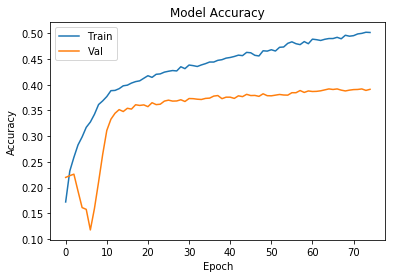

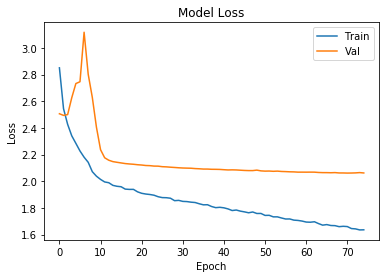

In [273]:
#muestro la accuracy del modelo
plot_acc(history1, title="Model Accuracy")
#muestro la loss del modelo
plot_loss(history1, title="Model Loss")

#### Evaluacion

In [305]:
score = model.evaluate(X_g_test, y_g_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

890/890 [==============================] - 0s 35us/step


In [306]:
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.7060788829674882
Test accuracy: 0.49775280885482104


#### Conclusiones

Aunuqe se pueden conseguir preciones cercanas al 70% (No ha sido posible con el modelo propuesto) con una RNN fully connected, se necesita mucho entrenamiento y el número de parámetros a calcular es muy grande conforme aumenta el tamaño de la imagen a procesar. Siendo en este caso, y para la primera capa, 16781312

### Mejoras del modelo: CNN

#### Definicion del modelo

In [277]:
IMG_ROWS=64
IMG_COLS=64
IMG_CHANNELS=3

def createModel_Conv2D():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345), 
                     input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=12345)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(18))
    model.add(Activation('sigmoid'))
    return model

(15193, 64, 64, 3)
(15193, 18)
(3799, 64, 64, 3)
(3799, 18)


In [278]:
model2 = createModel_Conv2D()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_34 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_152 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 64)        36928     
__________

In [279]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [280]:
VALIDATION_SPLIT=0.2
BATCH_SIZE=128
VERBOSE=1
NB_EPOCH = 50

history2 = model2.fit(X_train, y_train,
                     batch_size=BATCH_SIZE,
                     epochs=NB_EPOCH,
                     callbacks=[reduce_lr],# early_stop],
                     validation_split=VALIDATION_SPLIT,
                     #validation_data=(X_validate, y_validate), 
                     verbose=VERBOSE)

Train on 12154 samples, validate on 3039 samples
Epoch 1/50
12154/12154 [==============================] - 5s 422us/step - loss: 2.7100 - acc: 0.1925 - val_loss: 2.4305 - val_acc: 0.3481
Epoch 2/50
12154/12154 [==============================] - 3s 282us/step - loss: 2.4168 - acc: 0.3467 - val_loss: 2.2673 - val_acc: 0.3886
Epoch 3/50
12154/12154 [==============================] - 3s 280us/step - loss: 2.2524 - acc: 0.4124 - val_loss: 2.1451 - val_acc: 0.4603
Epoch 4/50
12154/12154 [==============================] - 4s 288us/step - loss: 2.0407 - acc: 0.4648 - val_loss: 1.7771 - val_acc: 0.4969
Epoch 5/50
12154/12154 [==============================] - 4s 289us/step - loss: 1.7504 - acc: 0.5313 - val_loss: 1.6339 - val_acc: 0.5489
Epoch 6/50
12154/12154 [==============================] - 3s 283us/step - loss: 1.4305 - acc: 0.6000 - val_loss: 1.2480 - val_acc: 0.6479
Epoch 7/50
12154/12154 [==============================] - 3s 288us/step - loss: 1.1512 - acc: 0.6771 - val_loss: 1.0088 - v

#### Gráficas del modelo

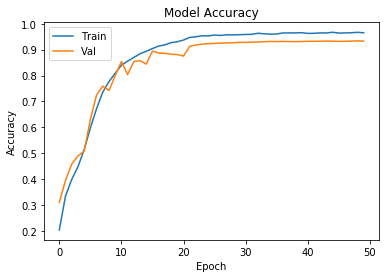

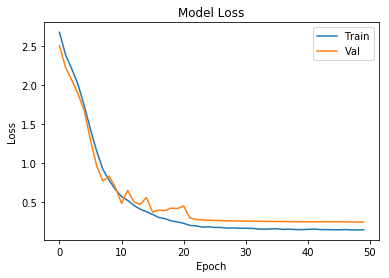

In [54]:
#muestro la accuracy del modelo
plot_acc(history2, title="Model Accuracy")
#muestro la loss del modelo
plot_loss(history2, title="Model Loss")

#### Evaluación del modelo

In [285]:
score=model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

890/890 [==============================] - 0s 148us/step


In [286]:
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.15636951437826907
Test accuracy: 0.9573033679737134


#### Análisis visual: Matriz de confusion

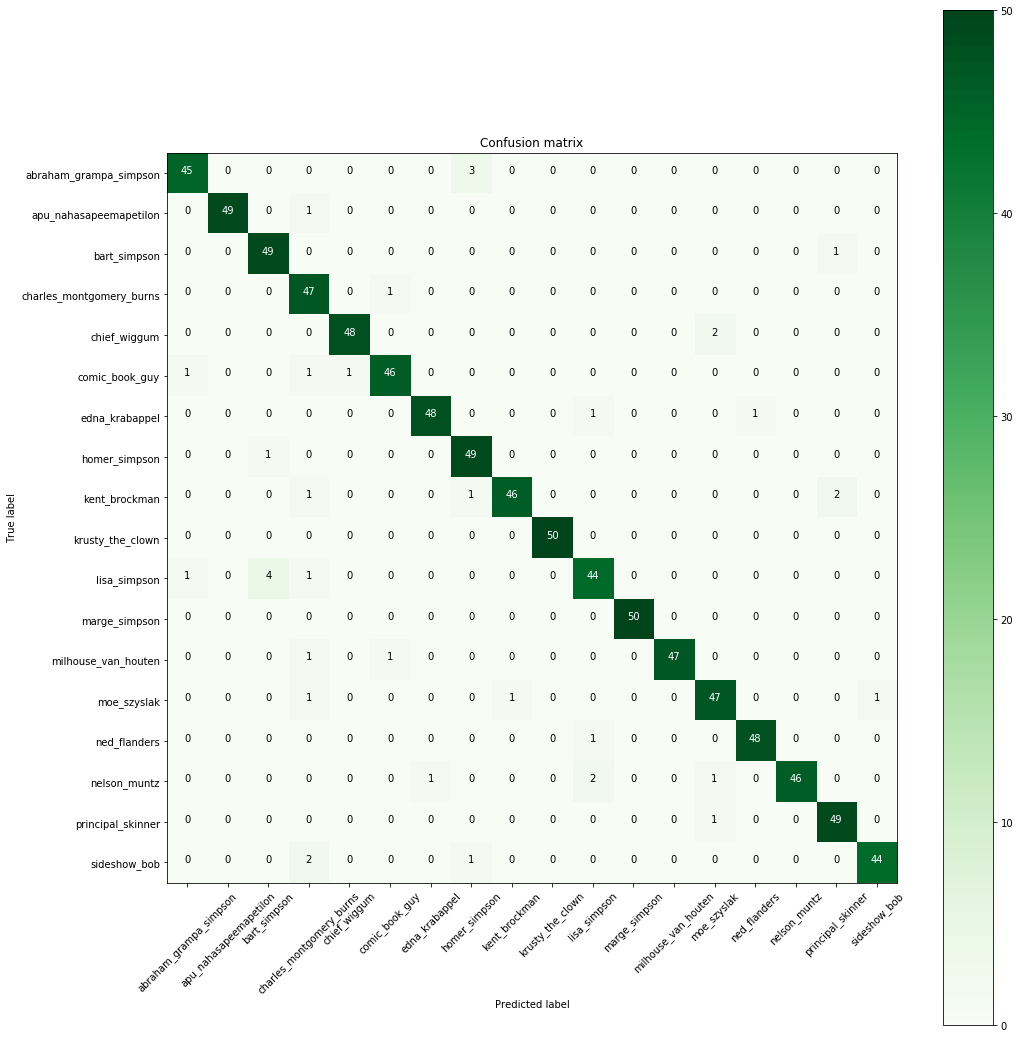

In [300]:
#Llamamos a la funcion predict de Keras.
y_pred = model2.predict(X_test)

#Creamos la matriz de confusion
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# La pintamos
plot_confusion_matrix(matrix, ['abraham_grampa_simpson', 
                               'apu_nahasapeemapetilon', 
                               'bart_simpson', 
                               'charles_montgomery_burns', 
                               'chief_wiggum', 
                               'comic_book_guy', 
                               'edna_krabappel',
                               'homer_simpson', 
                               'kent_brockman', 
                               'krusty_the_clown', 
                               'lisa_simpson',
                               'marge_simpson',
                               'milhouse_van_houten',
                               'moe_szyslak',
                               'ned_flanders', 
                               'nelson_muntz', 
                               'principal_skinner', 
                               'sideshow_bob'])

#### Conclusiones

A la vista de los resultados se puede concluir que el modelo es bastante preciso comparado con el Fully Connected. Además, aun teniendo 3 veces más capas, la suma total de los parametros a calcular es menor que la de la primera capa del Fully Connected, haciendo de las CNN un modelo más eficiente computacionalmente.

Para obtener el estos resultados, se han probado varias arquitecturas, siendo la que se muestra en el 2.4.1 la ganadora. Para la eleccion de los optimizadores e hiperparametros se ha decidido optar por los ganadores de la práctica 2, optimizador Adam con parametros por defecto e inicializador glorot_uniform. Se ha usado sigmoid como última función de activación para obtener scores de 0 a 1.

En cuanto a los fallos del modelo, las imágenes que la red ha detectado como Bart, en realidad eran imágenes de Lisa. Siendo este el par más problematico con 4 falsas detecciones. También ha tenido problemas con el abuelo Simpson y Homer, con 3 falsas detecciones.

### Data augmentation

#### Data Generator

In [311]:
from keras.preprocessing.image import ImageDataGenerator
 
Data_Generator = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=1.,
    horizontal_flip=True,
    vertical_flip=True)

#### Definicion del modelo

In [302]:
batch_size = 256
epochs = 500

model3 = createModel_Conv2D()
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the batches generated by datagen.flow().
history3 = model3.fit_generator(Data_Generator.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_validate.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(X_validate, y_validate),
                              workers=4)
 

Epoch 1/500
15/15 [==============================] - 4s 276ms/step - loss: 3.0842 - acc: 0.0729 - val_loss: 2.8800 - val_acc: 0.0824
Epoch 2/500
15/15 [==============================] - 1s 82ms/step - loss: 2.9843 - acc: 0.0898 - val_loss: 3.0844 - val_acc: 0.0784
Epoch 3/500
15/15 [==============================] - 1s 83ms/step - loss: 2.8941 - acc: 0.1023 - val_loss: 3.1199 - val_acc: 0.0837
Epoch 4/500
15/15 [==============================] - 2s 115ms/step - loss: 2.8236 - acc: 0.1190 - val_loss: 2.8078 - val_acc: 0.1361
Epoch 5/500
15/15 [==============================] - 1s 82ms/step - loss: 2.7796 - acc: 0.1437 - val_loss: 2.6098 - val_acc: 0.1958
Epoch 6/500
15/15 [==============================] - 1s 83ms/step - loss: 2.7469 - acc: 0.1544 - val_loss: 2.6100 - val_acc: 0.2011
Epoch 7/500
15/15 [==============================] - 1s 83ms/step - loss: 2.7236 - acc: 0.1732 - val_loss: 2.5434 - val_acc: 0.2432
Epoch 8/500
15/15 [==============================] - 1s 85ms/step - loss: 

15/15 [==============================] - 1s 83ms/step - loss: 1.6137 - acc: 0.5198 - val_loss: 1.3148 - val_acc: 0.6094
Epoch 63/500
15/15 [==============================] - 1s 83ms/step - loss: 1.5677 - acc: 0.5289 - val_loss: 1.1333 - val_acc: 0.6568
Epoch 64/500
15/15 [==============================] - 1s 86ms/step - loss: 1.5574 - acc: 0.5457 - val_loss: 1.2090 - val_acc: 0.6439
Epoch 65/500
15/15 [==============================] - 1s 84ms/step - loss: 1.5443 - acc: 0.5365 - val_loss: 1.0650 - val_acc: 0.6797
Epoch 66/500
15/15 [==============================] - 1s 84ms/step - loss: 1.5654 - acc: 0.5461 - val_loss: 1.0817 - val_acc: 0.6757
Epoch 67/500
15/15 [==============================] - 1s 84ms/step - loss: 1.5626 - acc: 0.5414 - val_loss: 1.1958 - val_acc: 0.6460
Epoch 68/500
15/15 [==============================] - 1s 85ms/step - loss: 1.5603 - acc: 0.5470 - val_loss: 1.2292 - val_acc: 0.6407
Epoch 69/500
15/15 [==============================] - 1s 84ms/step - loss: 1.4939 

15/15 [==============================] - 1s 83ms/step - loss: 1.1596 - acc: 0.6667 - val_loss: 0.6244 - val_acc: 0.8231
Epoch 124/500
15/15 [==============================] - 1s 84ms/step - loss: 1.1796 - acc: 0.6520 - val_loss: 0.7001 - val_acc: 0.7805
Epoch 125/500
15/15 [==============================] - 1s 82ms/step - loss: 1.1496 - acc: 0.6656 - val_loss: 0.6128 - val_acc: 0.8205
Epoch 126/500
15/15 [==============================] - 1s 83ms/step - loss: 1.1206 - acc: 0.6680 - val_loss: 0.6290 - val_acc: 0.8147
Epoch 127/500
15/15 [==============================] - 1s 82ms/step - loss: 1.1531 - acc: 0.6620 - val_loss: 0.7975 - val_acc: 0.7739
Epoch 128/500
15/15 [==============================] - 1s 85ms/step - loss: 1.1168 - acc: 0.6799 - val_loss: 0.6260 - val_acc: 0.8147
Epoch 129/500
15/15 [==============================] - 1s 82ms/step - loss: 1.1641 - acc: 0.6599 - val_loss: 0.5940 - val_acc: 0.8200
Epoch 130/500
15/15 [==============================] - 1s 88ms/step - loss: 

15/15 [==============================] - 1s 83ms/step - loss: 1.0093 - acc: 0.7071 - val_loss: 0.5482 - val_acc: 0.8381
Epoch 185/500
15/15 [==============================] - 1s 82ms/step - loss: 0.9919 - acc: 0.7073 - val_loss: 0.5499 - val_acc: 0.8405
Epoch 186/500
15/15 [==============================] - 1s 82ms/step - loss: 0.9937 - acc: 0.7156 - val_loss: 0.4871 - val_acc: 0.8592
Epoch 187/500
15/15 [==============================] - 1s 83ms/step - loss: 1.0550 - acc: 0.6987 - val_loss: 0.4623 - val_acc: 0.8652
Epoch 188/500
15/15 [==============================] - 1s 84ms/step - loss: 1.0202 - acc: 0.7089 - val_loss: 0.5291 - val_acc: 0.8492
Epoch 189/500
15/15 [==============================] - 1s 83ms/step - loss: 1.0121 - acc: 0.7107 - val_loss: 0.5334 - val_acc: 0.8500
Epoch 190/500
15/15 [==============================] - 1s 84ms/step - loss: 1.0031 - acc: 0.7117 - val_loss: 0.5059 - val_acc: 0.8473
Epoch 191/500
15/15 [==============================] - 1s 90ms/step - loss: 

15/15 [==============================] - 1s 86ms/step - loss: 0.9461 - acc: 0.7240 - val_loss: 0.4291 - val_acc: 0.8800
Epoch 246/500
15/15 [==============================] - 1s 86ms/step - loss: 0.9372 - acc: 0.7341 - val_loss: 0.4337 - val_acc: 0.8689
Epoch 247/500
15/15 [==============================] - 1s 84ms/step - loss: 0.9330 - acc: 0.7229 - val_loss: 0.5330 - val_acc: 0.8431
Epoch 248/500
15/15 [==============================] - 1s 87ms/step - loss: 0.9583 - acc: 0.7239 - val_loss: 0.4608 - val_acc: 0.8681
Epoch 249/500
15/15 [==============================] - 1s 85ms/step - loss: 0.9366 - acc: 0.7333 - val_loss: 0.4771 - val_acc: 0.8636
Epoch 250/500
15/15 [==============================] - 1s 82ms/step - loss: 0.9266 - acc: 0.7409 - val_loss: 0.4160 - val_acc: 0.8789
Epoch 251/500
15/15 [==============================] - 1s 83ms/step - loss: 0.9474 - acc: 0.7302 - val_loss: 0.3982 - val_acc: 0.8842
Epoch 252/500
15/15 [==============================] - 1s 84ms/step - loss: 

15/15 [==============================] - 1s 88ms/step - loss: 0.8560 - acc: 0.7542 - val_loss: 0.3487 - val_acc: 0.8971
Epoch 307/500
15/15 [==============================] - 1s 85ms/step - loss: 0.8953 - acc: 0.7435 - val_loss: 0.4648 - val_acc: 0.8771
Epoch 308/500
15/15 [==============================] - 1s 85ms/step - loss: 0.9015 - acc: 0.7455 - val_loss: 0.3530 - val_acc: 0.8994
Epoch 309/500
15/15 [==============================] - 1s 84ms/step - loss: 0.8590 - acc: 0.7536 - val_loss: 0.4180 - val_acc: 0.8850
Epoch 310/500
15/15 [==============================] - 1s 85ms/step - loss: 0.8929 - acc: 0.7401 - val_loss: 0.3863 - val_acc: 0.8894
Epoch 311/500
15/15 [==============================] - 1s 84ms/step - loss: 0.9061 - acc: 0.7372 - val_loss: 0.4144 - val_acc: 0.8776
Epoch 312/500
15/15 [==============================] - 1s 86ms/step - loss: 0.8571 - acc: 0.7481 - val_loss: 0.3452 - val_acc: 0.9010
Epoch 313/500
15/15 [==============================] - 1s 86ms/step - loss: 

15/15 [==============================] - 1s 83ms/step - loss: 0.8596 - acc: 0.7602 - val_loss: 0.3834 - val_acc: 0.8873
Epoch 368/500
15/15 [==============================] - 1s 84ms/step - loss: 0.8460 - acc: 0.7579 - val_loss: 0.3636 - val_acc: 0.8987
Epoch 369/500
15/15 [==============================] - 1s 83ms/step - loss: 0.8488 - acc: 0.7557 - val_loss: 0.3966 - val_acc: 0.8884
Epoch 370/500
15/15 [==============================] - 1s 83ms/step - loss: 0.8417 - acc: 0.7542 - val_loss: 0.3859 - val_acc: 0.8889
Epoch 371/500
15/15 [==============================] - 1s 83ms/step - loss: 0.8087 - acc: 0.7667 - val_loss: 0.3624 - val_acc: 0.8989
Epoch 372/500
15/15 [==============================] - 1s 84ms/step - loss: 0.7998 - acc: 0.7679 - val_loss: 0.3485 - val_acc: 0.9029
Epoch 373/500
15/15 [==============================] - 1s 83ms/step - loss: 0.8540 - acc: 0.7516 - val_loss: 0.4876 - val_acc: 0.8610
Epoch 374/500
15/15 [==============================] - 1s 82ms/step - loss: 

15/15 [==============================] - 1s 93ms/step - loss: 0.7801 - acc: 0.7683 - val_loss: 0.3355 - val_acc: 0.9047
Epoch 429/500
15/15 [==============================] - 1s 83ms/step - loss: 0.8047 - acc: 0.7656 - val_loss: 0.3398 - val_acc: 0.9029
Epoch 430/500
15/15 [==============================] - 1s 82ms/step - loss: 0.8045 - acc: 0.7625 - val_loss: 0.3423 - val_acc: 0.8981
Epoch 431/500
15/15 [==============================] - 1s 83ms/step - loss: 0.7803 - acc: 0.7776 - val_loss: 0.3412 - val_acc: 0.8994
Epoch 432/500
15/15 [==============================] - 1s 84ms/step - loss: 0.8128 - acc: 0.7615 - val_loss: 0.3082 - val_acc: 0.9087
Epoch 433/500
15/15 [==============================] - 1s 82ms/step - loss: 0.8174 - acc: 0.7578 - val_loss: 0.3234 - val_acc: 0.9121
Epoch 434/500
15/15 [==============================] - 1s 83ms/step - loss: 0.8325 - acc: 0.7576 - val_loss: 0.3627 - val_acc: 0.8981
Epoch 435/500
15/15 [==============================] - 1s 83ms/step - loss: 

15/15 [==============================] - 1s 83ms/step - loss: 0.7894 - acc: 0.7732 - val_loss: 0.2961 - val_acc: 0.9181
Epoch 490/500
15/15 [==============================] - 1s 84ms/step - loss: 0.7642 - acc: 0.7776 - val_loss: 0.3218 - val_acc: 0.9055
Epoch 491/500
15/15 [==============================] - 1s 83ms/step - loss: 0.7776 - acc: 0.7732 - val_loss: 0.3505 - val_acc: 0.9050
Epoch 492/500
15/15 [==============================] - 1s 84ms/step - loss: 0.8128 - acc: 0.7675 - val_loss: 0.3145 - val_acc: 0.9084
Epoch 493/500
15/15 [==============================] - 1s 83ms/step - loss: 0.7700 - acc: 0.7703 - val_loss: 0.3390 - val_acc: 0.8987
Epoch 494/500
15/15 [==============================] - 1s 82ms/step - loss: 0.8103 - acc: 0.7677 - val_loss: 0.3311 - val_acc: 0.9063
Epoch 495/500
15/15 [==============================] - 1s 83ms/step - loss: 0.7938 - acc: 0.7745 - val_loss: 0.3419 - val_acc: 0.9034
Epoch 496/500
15/15 [==============================] - 1s 84ms/step - loss: 

[0.2720123366191146, 0.9191011229257905]

#### Gráficas

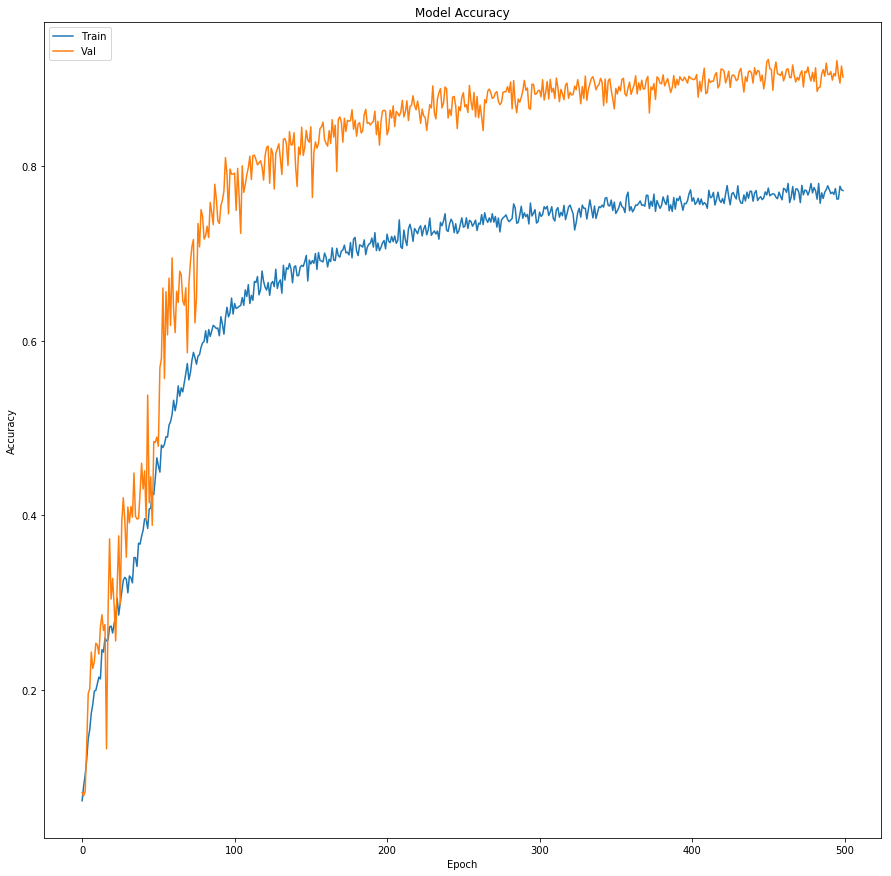

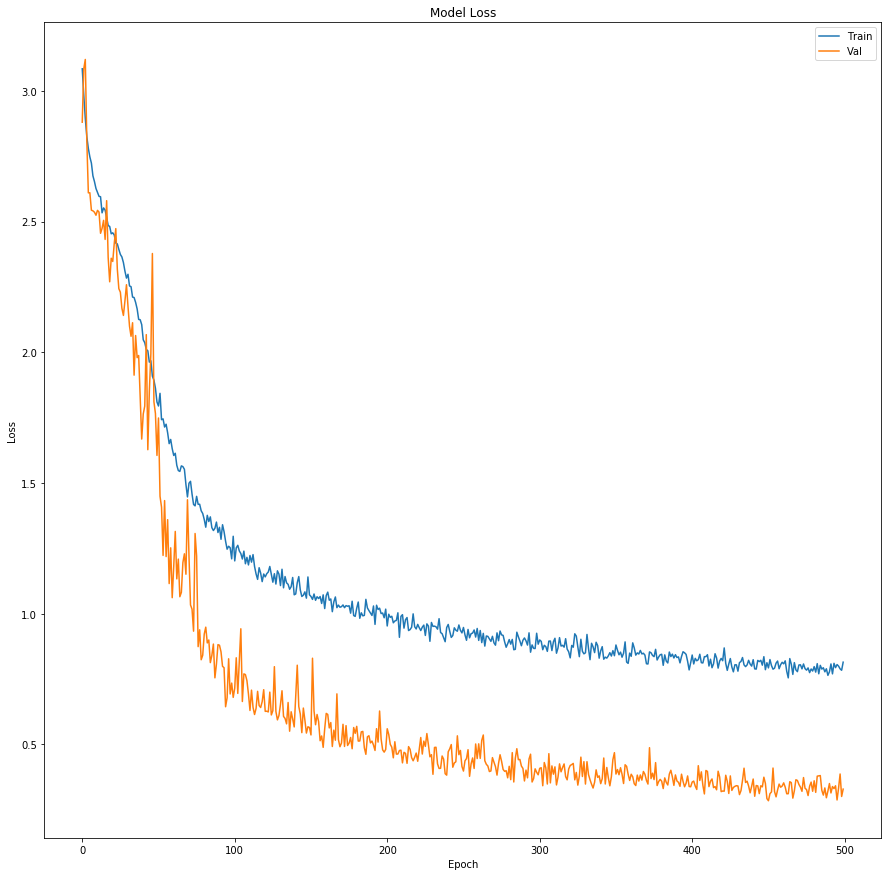

In [309]:
plot_acc(history3, title="Model Accuracy")
#muestro la loss del modelo
plot_loss(history3, title="Model Loss")

#### Evaluacion del Modelo

In [307]:
score = model3.evaluate(X_test, y_test)

890/890 [==============================] - 0s 154us/step


In [308]:
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2720123366191146
Test accuracy: 0.9191011229257905


#### Análisis visual

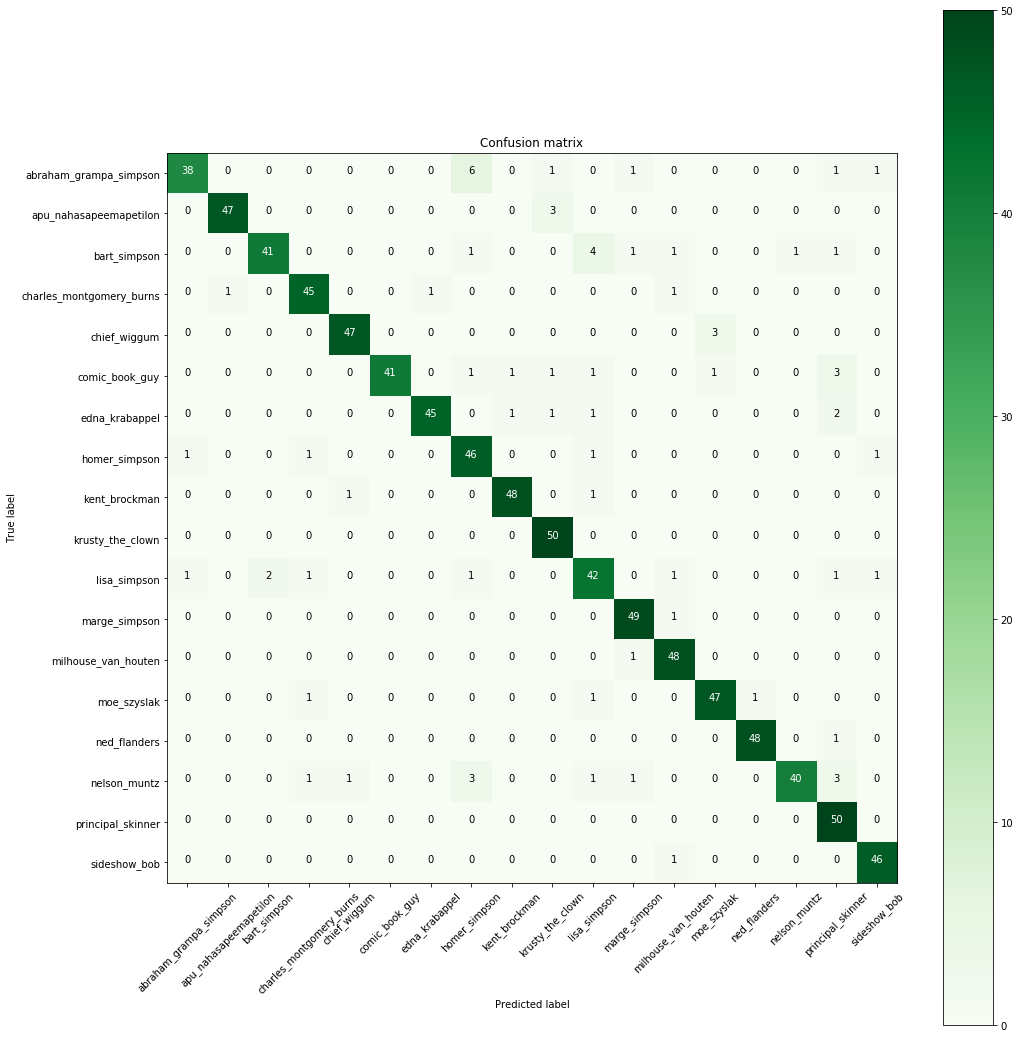

In [310]:
#Llamamos a la funcion predict de Keras.
y_pred = model3.predict(X_test)

#Creamos la matriz de confusion
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# La pintamos
plot_confusion_matrix(matrix, ['abraham_grampa_simpson', 
                               'apu_nahasapeemapetilon', 
                               'bart_simpson', 
                               'charles_montgomery_burns', 
                               'chief_wiggum', 
                               'comic_book_guy', 
                               'edna_krabappel',
                               'homer_simpson', 
                               'kent_brockman', 
                               'krusty_the_clown', 
                               'lisa_simpson',
                               'marge_simpson',
                               'milhouse_van_houten',
                               'moe_szyslak',
                               'ned_flanders', 
                               'nelson_muntz', 
                               'principal_skinner', 
                               'sideshow_bob'])

#### Conclusiones

Preguntar a tolosana

Si le meto mas epochs debería mejorar?
Es más robusto, pero ha fallado mas por tener poco entrenamiento?